In [8]:
# Importing the necessary libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
# loading the dataset
df = pd.read_csv('dataset.csv')
df.columns

Index(['order_id', 'customer_number', 'transaction_date', 'description',
       'total_qty', 'net_total', 'loyalty_amount', 'loyalty_points',
       'discount_amount', 'customer_group', 'territory', 'delivery_date',
       'delivery_window_end_time', 'delivery_window_start_time',
       'set_warehouse', 'duka_latitude', 'duka_longitude'],
      dtype='object')

In [12]:
# checking for null values
df.isna().sum()

order_id                      0
customer_number               0
transaction_date              0
description                   0
total_qty                     0
net_total                     0
loyalty_amount                0
loyalty_points                0
discount_amount               0
customer_group                0
territory                     0
delivery_date                 0
delivery_window_end_time      0
delivery_window_start_time    0
set_warehouse                 0
duka_latitude                 0
duka_longitude                0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43718 entries, 0 to 43717
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    43718 non-null  object 
 1   customer_number             43718 non-null  object 
 2   transaction_date            43718 non-null  object 
 3   description                 43718 non-null  object 
 4   total_qty                   43718 non-null  int64  
 5   net_total                   43718 non-null  float64
 6   loyalty_amount              43718 non-null  int64  
 7   loyalty_points              43718 non-null  int64  
 8   discount_amount             43718 non-null  float64
 9   customer_group              43718 non-null  object 
 10  territory                   43718 non-null  object 
 11  delivery_date               43718 non-null  object 
 12  delivery_window_end_time    43718 non-null  object 
 13  delivery_window_start_time  437

Looking at the `info` above it is clear that columns that represented time and dates aren't stored with the appropraite datatype which is `datetime`

In [17]:
datetime_columns = ['transaction_date', 'delivery_date', 'delivery_window_end_time', 'delivery_window_start_time']
df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43718 entries, 0 to 43717
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   order_id                    43718 non-null  object        
 1   customer_number             43718 non-null  object        
 2   transaction_date            43718 non-null  datetime64[ns]
 3   description                 43718 non-null  object        
 4   total_qty                   43718 non-null  int64         
 5   net_total                   43718 non-null  float64       
 6   loyalty_amount              43718 non-null  int64         
 7   loyalty_points              43718 non-null  int64         
 8   discount_amount             43718 non-null  float64       
 9   customer_group              43718 non-null  object        
 10  territory                   43718 non-null  object        
 11  delivery_date               43718 non-null  datetime64

The delivery time of an order can be obtained by getting the difference between `delivery_window_end_time` and `delivery_window_start_time`. This result will be a better feature for the model.

In [20]:
df['delivery_time'] = df['delivery_window_end_time'] - df['delivery_window_start_time']
df['delivery_time'].head()

0   0 days 06:00:00
1   0 days 06:00:00
2   0 days 06:00:00
3   0 days 06:00:00
4   0 days 06:00:00
Name: delivery_time, dtype: timedelta64[ns]

From the dataset provided, `churn` column hasn't been provided. In order to determine customers who have churned, I decided to analyse the `transaction date` in order to determine when difference in time between the first and last transaction.

In [23]:
# Determining last transaction date for each customer
last_transaction_date = df.groupby('customer_number')['transaction_date'].max().reset_index()
last_transaction_date.columns = ['customer_number', 'transaction_date']

# Finding the latest transaction date 
last_transaction_date['transaction_date'].max()

Timestamp('2022-03-31 00:00:00')

In [25]:
# Determining first transaction date for each customer
first_transaction_date = df.groupby('customer_number')['transaction_date'].min().reset_index()
first_transaction_date.columns = ['customer_number', 'transaction_date']

# Finding the first transaction date 
first_transaction_date['transaction_date'].min()

Timestamp('2022-02-09 00:00:00')

In [27]:
# Finding the difference between the first and last transaction.
last_transaction_date['transaction_date'].max() - first_transaction_date['transaction_date'].min()

Timedelta('50 days 00:00:00')

From the result above, the difference between the first and last transaction dates is 50 days. We can therefore set our churn threshold as one month(30 days).

Since we are primarily focusing on the `customer_number`, we will have to group by the customers in order to come up with the final dataset. This therefore means, that some aggregation will be done on some of the columns. It is also at this stage that we will drop some of features in the data.

In [31]:
df_churn = df.groupby('customer_number').agg({
    'transaction_date': 'max',                 # The latest transaction date of a specific customer
    'net_total': 'sum',                        # Total spend of each customer
    'loyalty_amount': 'sum',                   # Total loyalty amount of each customer
    'loyalty_points': 'sum',                   # Total loyalty points of each customer
    'discount_amount': 'mean',                 # Average discount of each customer
    'customer_group': lambda x: x.mode()[0],   # The most common customer_group for each customer
    'territory': lambda x: x.mode()[0],        # The most common territory for each customer
    'delivery_time': 'mean'                    # Average delivery time for each customer
}).reset_index()

# latest transaction date for each customer
latest_transaction_date = df_churn['transaction_date'].max()

churn_threshold = 30
df_churn['churn'] = (latest_transaction_date - df_churn['transaction_date']).dt.days > churn_threshold
df_churn.head()

,customer_number,transaction_date,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_time,churn
0,ID_000015,2022-03-23,229405.77,0,0,115.387436,Individual,Ruiru,0 days 06:00:00,False
1,ID_000088,2022-03-31,563832.56,0,0,148.304310,Individual,Majengo Mombasa,0 days 06:02:04.103448275,False
2,ID_000117,2022-03-14,68617.23,0,0,268.000000,Individual,Thika Rd,0 days 06:00:00,False
3,ID_000131,2022-03-25,277724.08,0,0,459.542000,Individual,Embu,0 days 06:00:00,False
4,ID_000150,2022-03-24,282362.46,0,0,115.484324,Individual,Juja,0 days 06:00:00,False


In [32]:
# Converting the churn column to 0 and 1 instead of true or false
df_churn['churn'] = df_churn['churn'].map({True:1, False:0})
df_churn.head()

,customer_number,transaction_date,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_time,churn
0,ID_000015,2022-03-23,229405.77,0,0,115.387436,Individual,Ruiru,0 days 06:00:00,0
1,ID_000088,2022-03-31,563832.56,0,0,148.304310,Individual,Majengo Mombasa,0 days 06:02:04.103448275,0
2,ID_000117,2022-03-14,68617.23,0,0,268.000000,Individual,Thika Rd,0 days 06:00:00,0
3,ID_000131,2022-03-25,277724.08,0,0,459.542000,Individual,Embu,0 days 06:00:00,0
4,ID_000150,2022-03-24,282362.46,0,0,115.484324,Individual,Juja,0 days 06:00:00,0


### Exploratory Data Analysis

In [36]:
df_churn.describe()

,transaction_date,net_total,loyalty_amount,loyalty_points,discount_amount,delivery_time,churn
count,3397,3.397000e+03,3397.0,3397.0,3397.000000,3397,3397.000000
mean,2022-03-19 23:16:20.276714752,1.346727e+05,0.0,0.0,164.558036,0 days 06:00:25.793660272,0.102149
min,2022-02-10 00:00:00,1.810300e+02,0.0,0.0,0.000000,0 days 05:00:00,0.000000
25%,2022-03-14 00:00:00,1.153840e+04,0.0,0.0,42.286667,0 days 06:00:00,0.000000
50%,2022-03-24 00:00:00,3.690310e+04,0.0,0.0,73.816000,0 days 06:00:00,0.000000
75%,2022-03-29 00:00:00,1.174219e+05,0.0,0.0,141.320513,0 days 06:00:00,0.000000
max,2022-03-31 00:00:00,2.012201e+07,0.0,0.0,8856.250000,0 days 06:59:59,1.000000
std,NaN,4.855483e+05,0.0,0.0,382.196446,0 days 00:04:31.566856937,0.302889


From the `describe` method above, we can already see some meaningful insights that help us understand the data better such as:

1. The average `delivery_time` is about 6 hours with the minimum time being 5 hours and the maximum being almost 7 hours
2. The `discount_amount` varies widely among the customers. This is evident from the average being 165 while the minimum discount amount is 0 and the maximum is almost 8856. This is further reinforced with the high standard devation value of the discount_amount.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

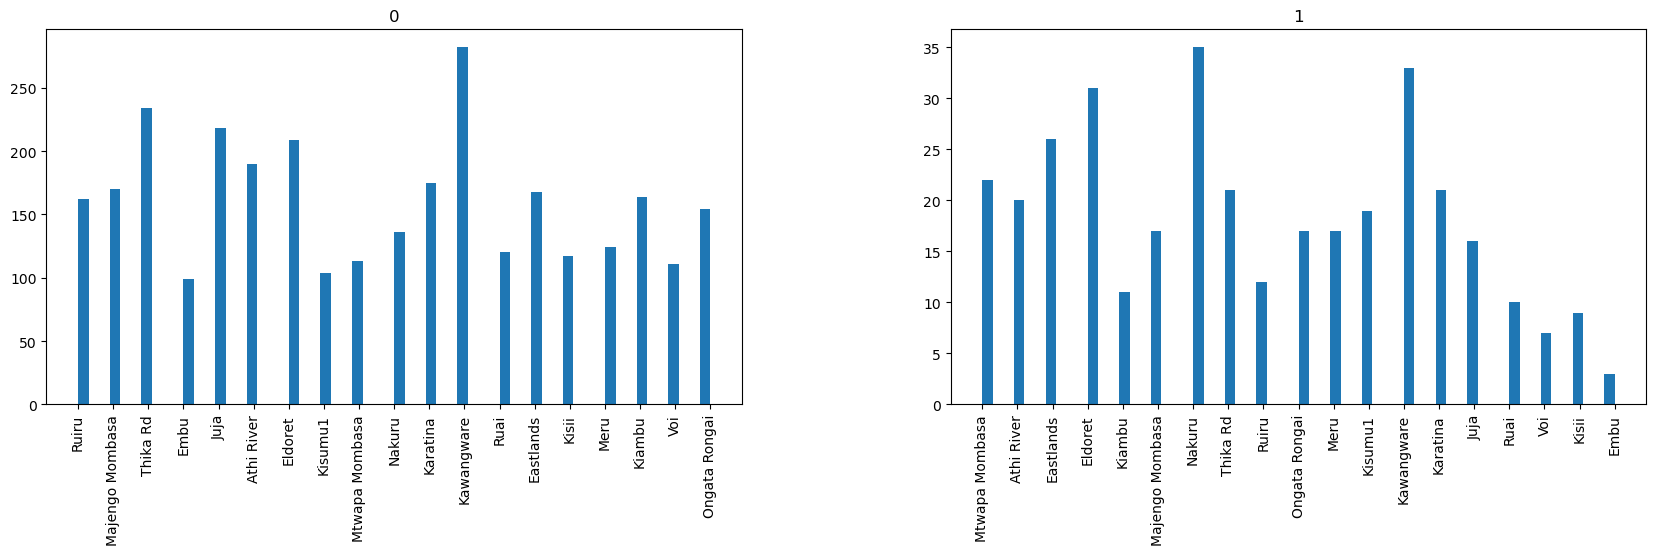

In [39]:
df_churn.hist(column='territory', by='churn', figsize=(20,5), bins=60)

From the visualization above, we can see that some areas have a high churn such as Nakuru, Kawangware and Eldoret with other areas having a lower churn rate such as Embu, Voi and Kisii. This visualization, however, doesn't give us adirect comparison with those that haven't churned so it may be difficult to know the churn rate of a certain territory. This can be solve by the use of a stacked barplot.

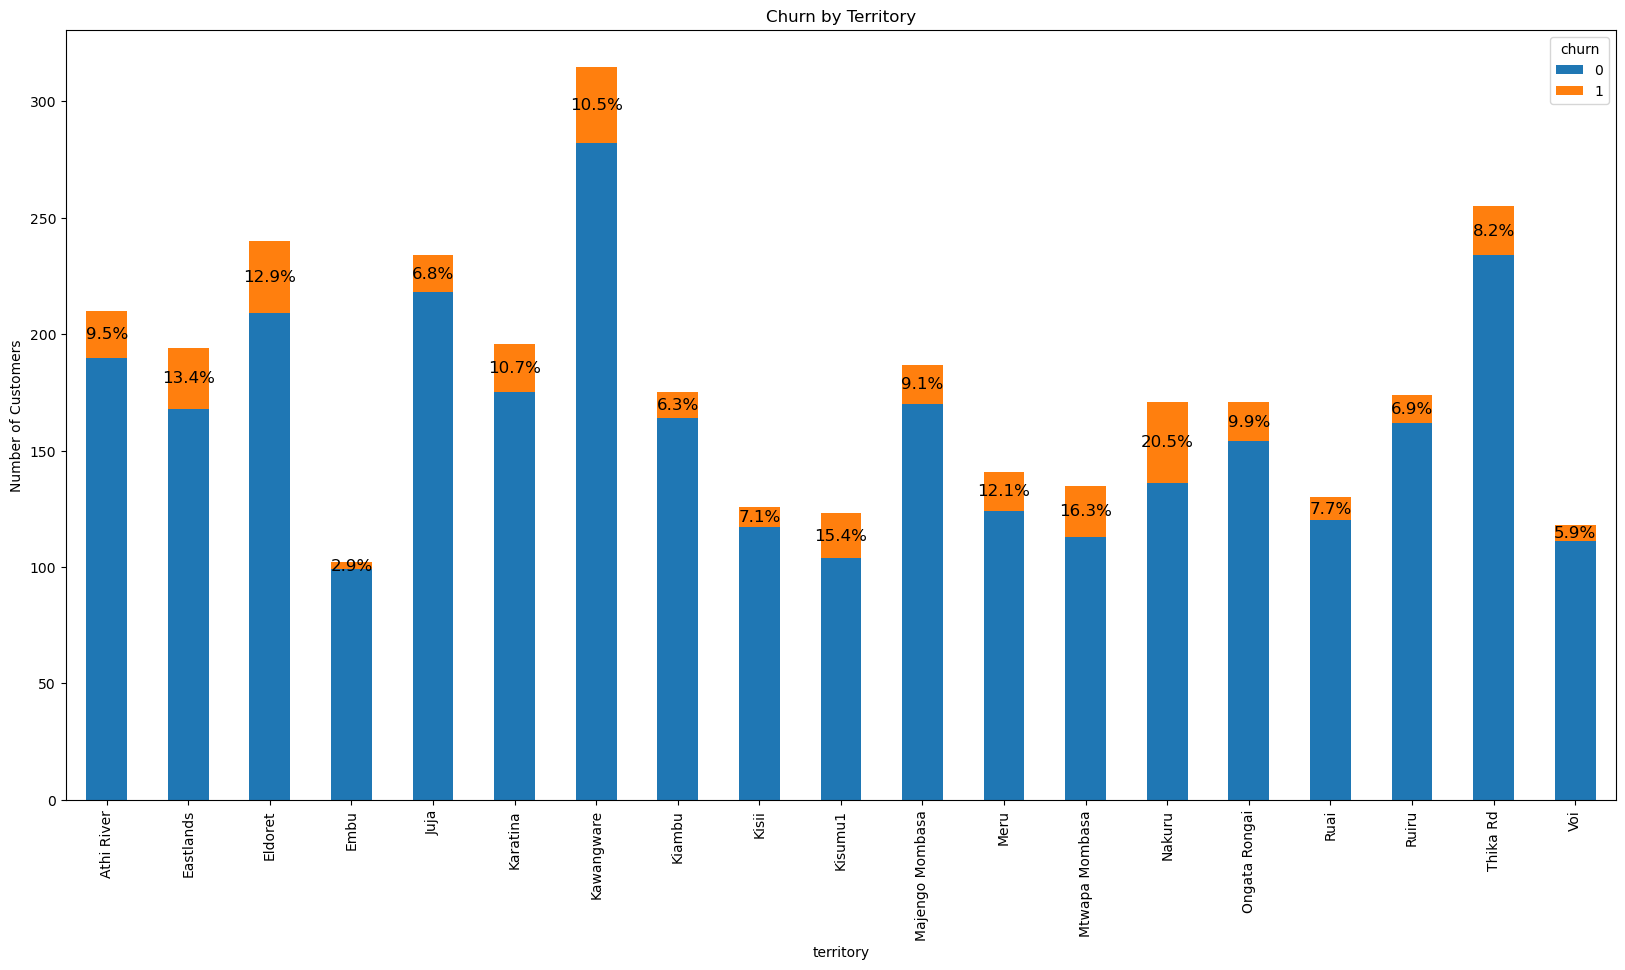

In [42]:
# stacked bar plot
churn_counts = df_churn.groupby(['territory', 'churn']).size().unstack()

# Total number of customers in each territory
churn_counts['Total'] = churn_counts.sum(axis=1)

# Calculating churn percentage
churn_counts['Churn_Percentage'] = (churn_counts[1] / churn_counts['Total']) * 100
churn_counts = churn_counts.drop(columns='Total')

# plotting
fig, ax = plt.subplots(figsize=(20, 10))
churn_counts[[0, 1]].plot(kind='bar', stacked=True, ax=ax)

# Annotating with percentages
for i in range(len(churn_counts)):
    churn_pct = churn_counts['Churn_Percentage'].iloc[i]
    ax.text(i, churn_counts[0].iloc[i] + churn_counts[1].iloc[i] / 2,
            f'{churn_pct:.1f}%', ha='center', va='center', color='black', fontsize=12)

plt.figsize = (20,10)
plt.title('Churn by Territory')
plt.ylabel('Number of Customers')
plt.show()

From the stacked barplot we can now see the actual rate of churn in different territories with some areas having a very high churn rate such as Nakuru, Eldoret and Karatina. Some areas have a relatively small population but still have a significant churn rate such as Kisumu, Meru and Mtwapa Mombasa.

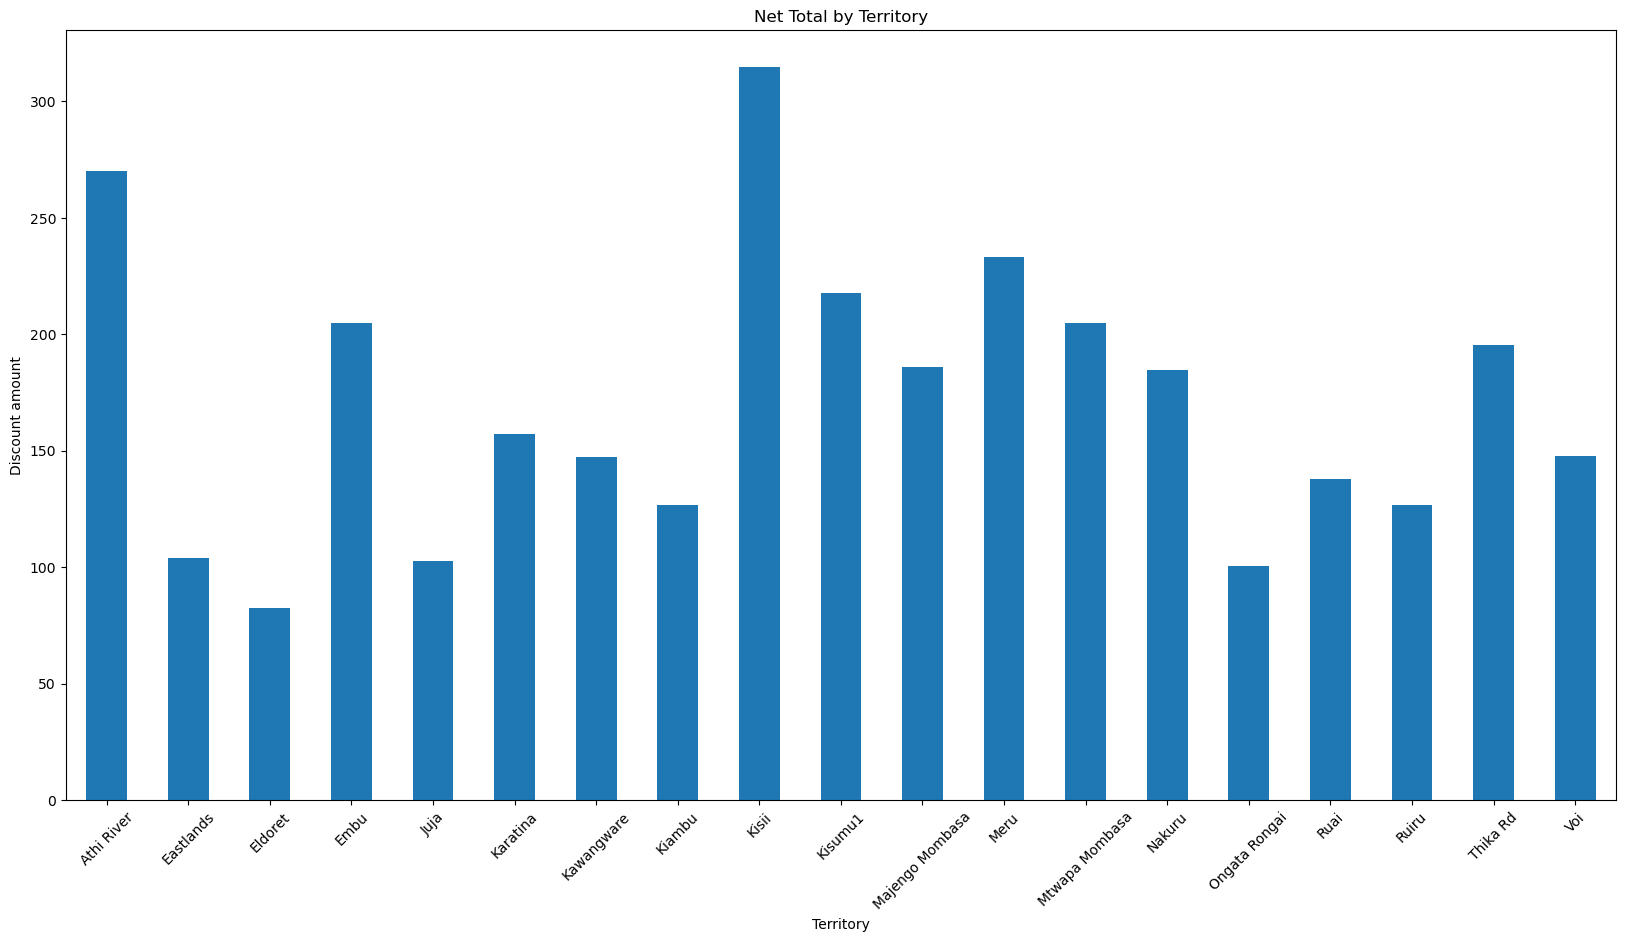

In [45]:
# Checking the average discount amount by territory
plt.figure(figsize=(20,10))
df_churn.groupby('territory')['discount_amount'].mean().plot(kind='bar')
plt.title('Net Total by Territory')
plt.xlabel('Territory')
plt.ylabel('Discount amount')
plt.xticks(rotation=45)
plt.show()

From the visualization above, we can see the reason for high churn rate in some areas is due to the low discount amount in those areas such as Eastlands, Eldoret and Nakuru.

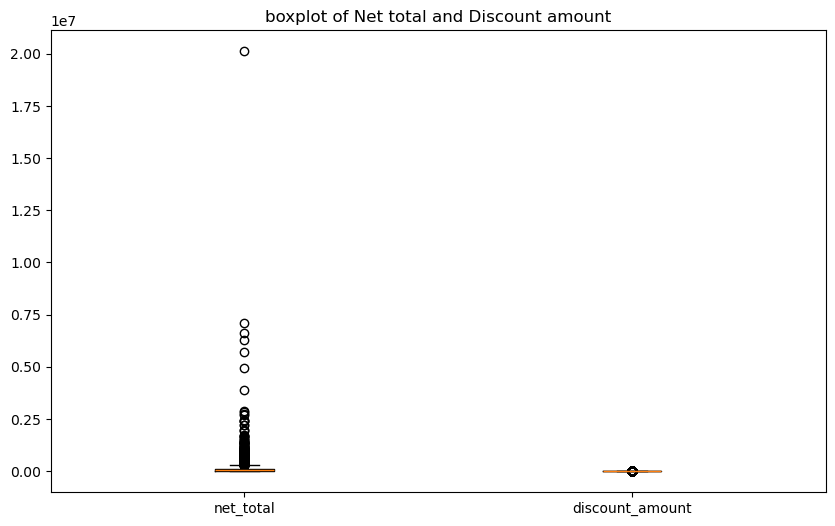

In [48]:
plt.figure(figsize=(10,6))
plt.boxplot([df_churn['net_total'], df_churn['discount_amount']],
            labels=['net_total', 'discount_amount'])
plt.title('boxplot of Net total and Discount amount')
plt.show()

From the Boxplot above, there is heavy presence of outliers in the `net_total` column. This will be dealt with by scaling the data before we train the machine learning model.

Now that we have a better understanding of the data, we can now give some recommendations on how to reduce customer churn:

1. Increase the discount amount is some of the most affected areas such as Eastlands, Eldoret and Nakuru.
2. Given that all the customers in this dataset do not have loyalty points, we suggest advertising and educating them on the loyalty points and give various benefits based on those points.
3. The average delivery period is about 6 hours. If this can be reduced it may see a significant reduction in churn rate among the customers.

### Model

For the machine learning model, <b>Decision Trees</b> will be used since it has several advantages for this case such as:

1. Easy to train and interpret especially when the dataset isn't that huge as in our case.
2. Decision Trees doesn't use any distance metrics therefore it is able to handle outliers robustly without the need of scaling.
3. Decision Trees parameter can be tuned to be able to adjust the weights given to classes hence it able to handle imbalanced classes.

Before the model is trained, there is still some feature engineering to be done. Firstly, the `transaction_date` has to be dropped since it was only used to group the data and come up with the churn column. Secondly, the `delivery_time` in its current format doesn't contribute heavily to the model hence it will be exploded.

In [54]:
df_p = df_churn.drop(columns=['transaction_date'])
df_p.head()

,customer_number,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_time,churn
0,ID_000015,229405.77,0,0,115.387436,Individual,Ruiru,0 days 06:00:00,0
1,ID_000088,563832.56,0,0,148.304310,Individual,Majengo Mombasa,0 days 06:02:04.103448275,0
2,ID_000117,68617.23,0,0,268.000000,Individual,Thika Rd,0 days 06:00:00,0
3,ID_000131,277724.08,0,0,459.542000,Individual,Embu,0 days 06:00:00,0
4,ID_000150,282362.46,0,0,115.484324,Individual,Juja,0 days 06:00:00,0


In [56]:
# Exploding the delivery period column
df_p['delivery_time_hour'] = df_p['delivery_time'].dt.components['hours']
df_p['delivery_time_min'] = df_p['delivery_time'].dt.components['minutes']
df_p['delivery_time_sec'] = df_p['delivery_time'].dt.components['seconds']

df_p.head()

,customer_number,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_time,churn,delivery_time_hour,delivery_time_min,delivery_time_sec
0,ID_000015,229405.77,0,0,115.387436,Individual,Ruiru,0 days 06:00:00,0,6,0,0
1,ID_000088,563832.56,0,0,148.304310,Individual,Majengo Mombasa,0 days 06:02:04.103448275,0,6,2,4
2,ID_000117,68617.23,0,0,268.000000,Individual,Thika Rd,0 days 06:00:00,0,6,0,0
3,ID_000131,277724.08,0,0,459.542000,Individual,Embu,0 days 06:00:00,0,6,0,0
4,ID_000150,282362.46,0,0,115.484324,Individual,Juja,0 days 06:00:00,0,6,0,0


Now that the `delivery_time` column has been exploded to its constituent details, the feature can be dropped. The `customer_number` can also be dropped since it is just a unique identifier therefore it doesn't contribute heavily to the machine learning model.

In [59]:
df_p.drop(['delivery_time', 'customer_number'], axis=1, inplace=True)
df_p.head()

,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,churn,delivery_time_hour,delivery_time_min,delivery_time_sec
0,229405.77,0,0,115.387436,Individual,Ruiru,0,6,0,0
1,563832.56,0,0,148.304310,Individual,Majengo Mombasa,0,6,2,4
2,68617.23,0,0,268.000000,Individual,Thika Rd,0,6,0,0
3,277724.08,0,0,459.542000,Individual,Embu,0,6,0,0
4,282362.46,0,0,115.484324,Individual,Juja,0,6,0,0


The next step involves encoding the data specifically the `customer_group` and `territory` features.

In [62]:
# Label encoding for the territory feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_p['territory'] = le.fit_transform(df_p['territory'])

# Getting dummy variables for the customer group feature hence using onehot encoding
df_p = pd.get_dummies(df_p, columns=['customer_group'])
df_p.head()

# Changing the dummy variables to integers
df_p[['customer_group_All Customer Groups', 'customer_group_Individual']] = df_p[['customer_group_All Customer Groups', 'customer_group_Individual']].astype(int)
df_p.head()

,net_total,loyalty_amount,loyalty_points,discount_amount,territory,churn,delivery_time_hour,delivery_time_min,delivery_time_sec,customer_group_All Customer Groups,customer_group_Individual
0,229405.77,0,0,115.387436,16,0,6,0,0,0,1
1,563832.56,0,0,148.304310,10,0,6,2,4,0,1
2,68617.23,0,0,268.000000,17,0,6,0,0,0,1
3,277724.08,0,0,459.542000,3,0,6,0,0,0,1
4,282362.46,0,0,115.484324,4,0,6,0,0,0,1


<Axes: xlabel='churn'>

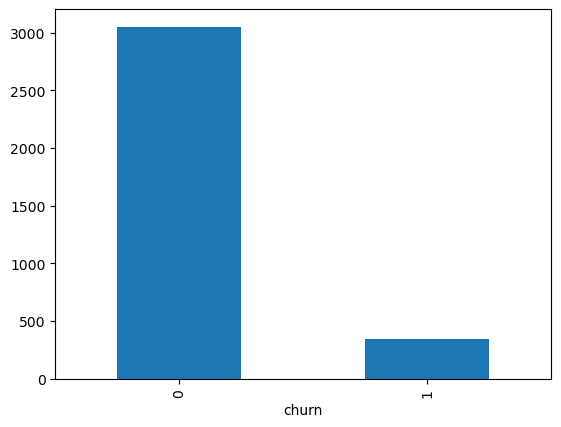

In [64]:
# Checking for class imbalance in the target variable
df_p['churn'].value_counts().plot(kind='bar')

As seen from the bar plot, the classes of the target variable are heavily imbalanced. This has to be kept in mind when tuning the machine learning model.

The next step involves splitting the dataset into a train and test set. For this situation, 75% of the data will be used for training the model and 25% for testing. It is also at this point that it should be said the main evaluation metric used will `precision` and `recall`.

In [67]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [68]:
# Separating features from the target variable
X = df_p.drop(columns=['churn'])
y = df_p['churn']

In [71]:
# Splitting the data into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

# Instatiating the classifier
clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=None)

# Fitting the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

Taking a look at the parameters in the `DecisionTreeClassifier` there are some key things to note:

1. The `criterion` chosen is <b>entropy</b> which determines the quality of a split by <b>Information Gain</b>.
2. Remember the classes of the target variable `churn` are heavily imbalanced. To cope with this, the `class_weight` has been set to <b>balanced</b> to automatically adjust the class weights inversely proportional to class frequencies. This will make the model pay more attention to minority classes during training hence dealing with the class imbalance.
3. The `max_depth` has been set <b>None</b> which allows the tree to grow until all leaves are pure ensuring all details are captured.

In [74]:
# Generating predictions for model evaluation
y_pred = clf.predict(X_test)

### Model Evaluation

In [77]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       757
           1       0.34      0.32      0.33        93

    accuracy                           0.86       850
   macro avg       0.63      0.62      0.63       850
weighted avg       0.85      0.86      0.86       850



The `precision` and `recall` is high for one of the classes but poor in the other. This is however, expected because as you recall, the classes were imbalanced. This is further reinforced with the lower `recall` and `precision` on the `macro avg` but higher in the `weighted avg`. This is because the `weighted avg` provides an average that considers class imbalances by giving more weight to classes with larger support making it useful when you want to assess the overall performance of the model while taking class imbalances into account.

The `accuracy` also seems to be high though it is not highly considered for this case as it can be a misleading metric when dealing with imbalanced classes.

In [89]:
# Generating final dataset
final_df = df_churn[['customer_number', 'churn']]
final_df.head()

,customer_number,churn
0,ID_000015,0
1,ID_000088,0
2,ID_000117,0
3,ID_000131,0
4,ID_000150,0
